#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

#### Loading the data into dataframe from the CSV file

In [ ]:
# Reading the CSV file in chunks to manage memory usage
chunk_size = 100  # Load 100 rows at a time
chunks = []
label_counts = {}
csv_file = '../assets/image_dataset/train/tomatoes_dataset.csv'

for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
    chunks.append(chunk)
    
    # Count labels
    for label in chunk['label'].value_counts().items():
        label_counts[label[0]] = label_counts.get(label[0], 0) + label[1]
    
    if (i + 1) % 10 == 0:
        print(f"Loaded {(i + 1) * chunk_size} rows...")

Loaded 1000 rows...
Loaded 2000 rows...
Loaded 3000 rows...
Loaded 4000 rows...
Loaded 5000 rows...
Loaded 6000 rows...
Loaded 7000 rows...
Loaded 8000 rows...
Loaded 9000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 10000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 11000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 12000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 13000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 14000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 15000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 16000 rows...
Loaded 17000 rows...
Loaded 18000 rows...
Loaded 19000 rows...
Loaded 20000 rows...
Loaded 21000 rows...
Loaded 22000 rows...
Loaded 23000 rows...
Loaded 24000 rows...
Loaded 25000 rows...
Loaded 26000 rows...
Loaded 27000 rows...
Loaded 28000 rows...
Loaded 29000 rows...
Loaded 30000 rows...
Loaded 31000 rows...
Loaded 32000 rows...
Loaded 33000 rows...
Loaded 34000 rows...
Loaded 35000 rows...
Loaded 36000 rows...
Loaded 37000 rows...
Loaded 38000 rows...
Loaded 39000 rows...
Loaded 40000 rows...
Loaded 41000 rows...
Loaded 42000 rows...
Loaded 43000 rows...
Loaded 44000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.

Loaded 45000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.

Loaded 46000 rows...


/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
/tmp/ipykernel_7214/3251256285.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 47000 rows...
Loaded 48000 rows...
Loaded 49000 rows...
Loaded 50000 rows...
Loaded 51000 rows...
Loaded 52000 rows...


In [ ]:
# Combining chunks 
df = pd.concat(chunks, ignore_index=True)
del chunks  # Free memory

df.shape

print(f"Total tomatoes: {len(df)}")

df.head(1)

Total tomatoes: 55719


,image_name,tomato_id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_12279,pixel_12280,pixel_12281,pixel_12282,pixel_12283,pixel_12284,pixel_12285,pixel_12286,pixel_12287,label
0,001_jpg.rf.5c347afc56aec22b9257d84d363ba621.jpg,0,255,230,220,254,229,219,254,231,...,241,222,219,241,222,219,240,221,218,2


#### Sampling the dataset since it is too large

In [ ]:
sample_size = 10000  # Use 10000 tomatoes
if len(df) > sample_size:
    df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    df.shape

#### Preparing data for training

In [ ]:
# Separate features and labels
X = df.drop(['image_name', 'tomato_id', 'label'], axis=1)
y = df['label']

X.shape
X.shape[1]

12288

In [ ]:
# Convert to string, remove 'class_' prefix, then to int
y = y.astype(str).str.replace('class_', '').astype(int)

# Map numeric labels to fresh or rotten
label_mapping = {
    0: 'fresh',      # 0 = very_good
    1: 'fresh',      # 1 = good
    2: 'rotten',     # 2 = bad
    3: 'rotten',     # 3 = very_bad
}

y_binary = y.map(label_mapping)
y_binary.value_counts()

label
rotten    7816
fresh     2171
Name: count, dtype: int64

In [ ]:
y_binary.isnull().sum()

# Remove unmapped rows
valid_mask = y_binary.notna()
X = X[valid_mask].reset_index(drop=True)
y_binary = y_binary[valid_mask].reset_index(drop=True)

#### Data preprocessing

###### Handling missing and infinite values

In [ ]:
# Check for missing values 
X.isnull().sum().sum()
# replace missing values with 0
X.fillna(0, inplace=True)

# Check for infinite values
np.isinf(X.values).sum()
# replace infinite values with 0
X.replace([np.inf, -np.inf], 0, inplace=True)

###### Normalize the pixel values from 0-255 to 0-1

In [ ]:
X_normalized = X / 255.0

np.isnan(X_normalized.values).sum()
X_normalized = X_normalized.fillna(0)

###### Standardization

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_normalized)
X_scaled.shape

np.isnan(X_scaled).sum()
np.isinf(X_scaled).sum()

X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

###### Check for constant features

In [ ]:
feature_variance = np.var(X_scaled, axis=0)
n_constant = np.sum(feature_variance == 0)

non_constant_mask = feature_variance > 0
X_scaled = X_scaled[:, non_constant_mask]

X_scaled.shape

(9987, 12288)

###### PCA

In [ ]:
# Choose number of components
n_components = min(50, X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Final check for NaN/Inf
np.isnan(X_pca).sum()
np.isinf(X_pca).sum()

X_pca = np.nan_to_num(X_pca, nan=0.0, posinf=0.0, neginf=0.0)


X_pca.shape

(9987, 50)

#### SPLIT DATA (Train/Test)

In [ ]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 7989
Test set size: 1998


#### TRAIN K-MEANS MODEL

In [ ]:
# Since we have 2 categories (fresh/rotten), we use k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
kmeans.fit(X_train)

print("Training complete!")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")
print(f"Inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")

Training complete!
Cluster centers shape: (2, 50)
Inertia (within-cluster sum of squares): 61659806.78


#### MAP CLUSTERS TO LABELS

In [ ]:
# Predict clusters for training data
train_clusters = kmeans.predict(X_train)

# Find which cluster corresponds to which label
cluster_label_mapping = {}
for cluster_id in range(k):
    mask = train_clusters == cluster_id
    labels_in_cluster = y_train[mask]
    
    if len(labels_in_cluster) > 0:
        most_common = labels_in_cluster.mode()[0]
        cluster_label_mapping[cluster_id] = most_common
        
        print(f"\nCluster {cluster_id}:")
        print(labels_in_cluster.value_counts())
        print(f"  -> Mapped to: {most_common}")
    else:
        print(f"\nCluster {cluster_id}: EMPTY")
        cluster_label_mapping[cluster_id] = 'unknown'

print(f"\nFinal mapping: {cluster_label_mapping}")


Cluster 0:
label
rotten    2967
fresh      778
Name: count, dtype: int64
  -> Mapped to: rotten

Cluster 1:
label
rotten    3285
fresh      959
Name: count, dtype: int64
  -> Mapped to: rotten

Final mapping: {0: 'rotten', 1: 'rotten'}


#### MAKE PREDICTIONS

In [ ]:
# Predict on training set
train_cluster_pred = kmeans.predict(X_train)
y_train_pred = pd.Series([cluster_label_mapping[c] for c in train_cluster_pred])

# Predict on test set
test_cluster_pred = kmeans.predict(X_test)
y_test_pred = pd.Series([cluster_label_mapping[c] for c in test_cluster_pred])

#### EVALUATE MODEL

In [ ]:

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['fresh', 'rotten'])
print(cm)

Training Accuracy: 0.7826 (78.26%)
Test Accuracy: 0.7828 (78.28%)
              precision    recall  f1-score   support

       fresh       0.00      0.00      0.00       434
      rotten       0.78      1.00      0.88      1564

    accuracy                           0.78      1998
   macro avg       0.39      0.50      0.44      1998
weighted avg       0.61      0.78      0.69      1998

[[   0  434]
 [   0 1564]]


/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

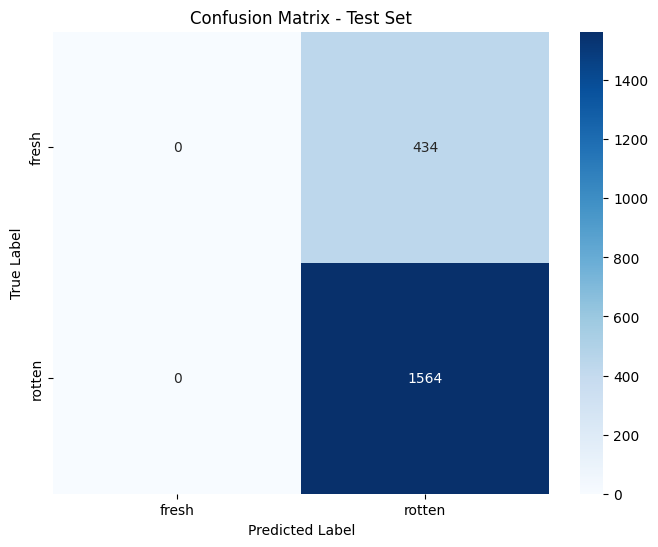

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['fresh', 'rotten'], 
            yticklabels=['fresh', 'rotten'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### VISUALIZE CLUSTERS

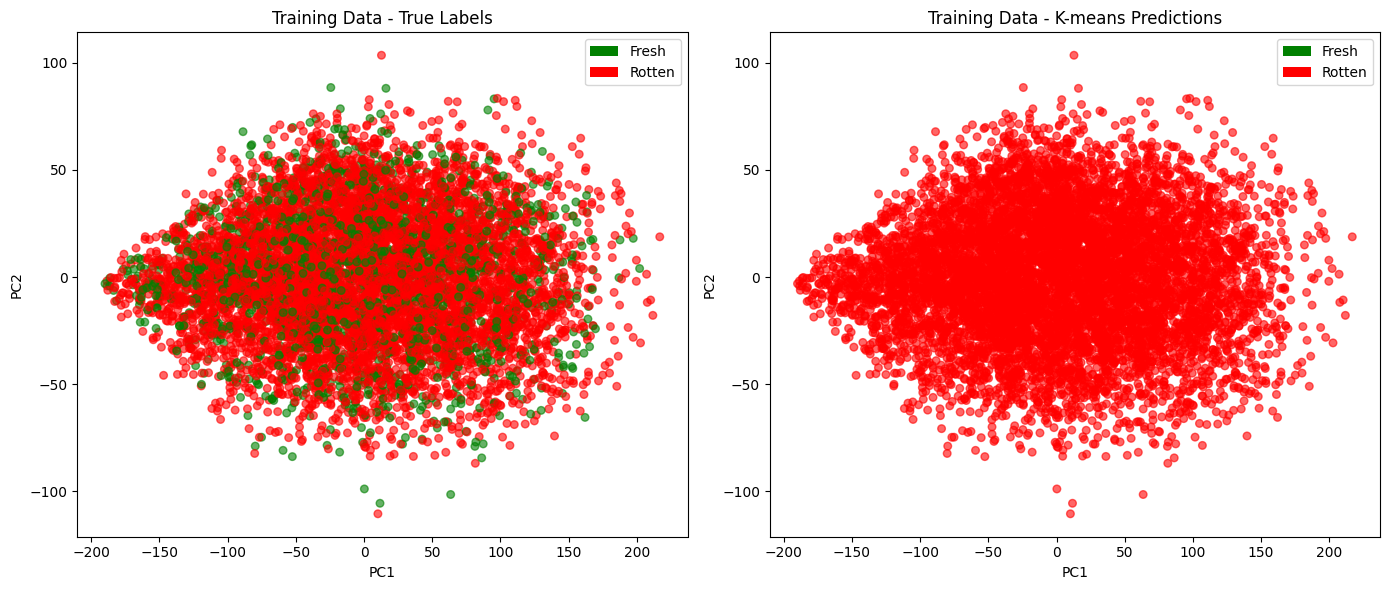

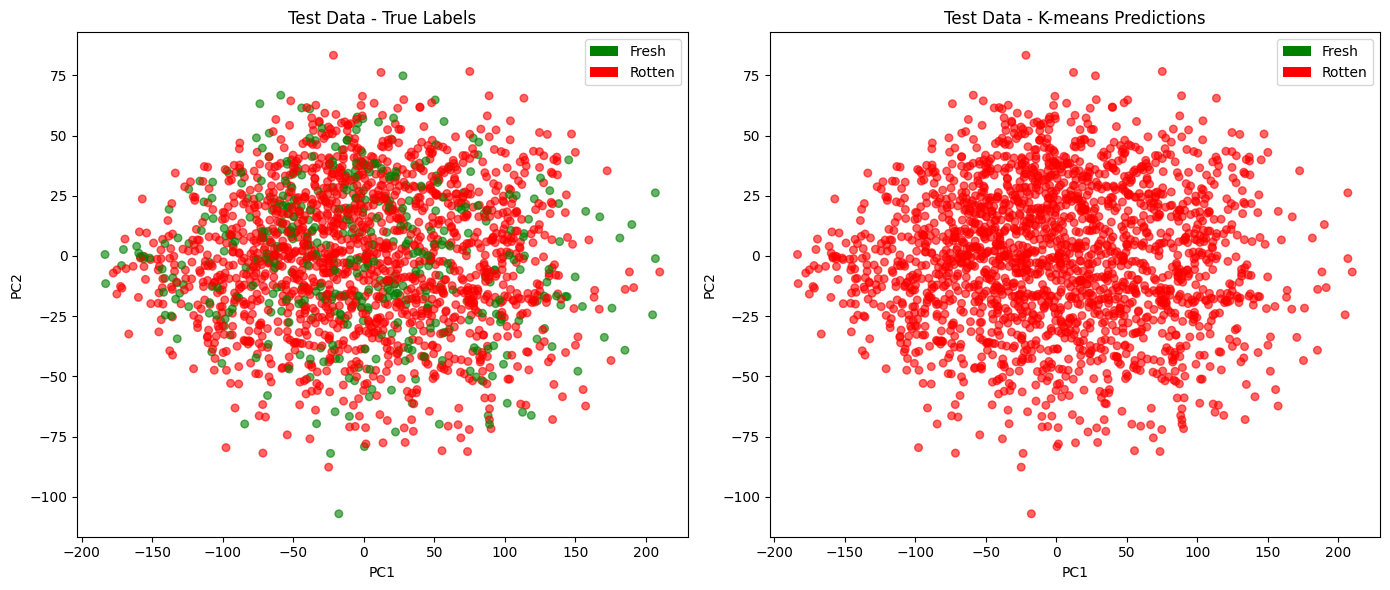

In [ ]:
# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train)
X_test_2d = pca_2d.transform(X_test)

# Plot training data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['green' if label == 'fresh' else 'red' for label in y_train]
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=colors, alpha=0.6, s=30)
plt.title('Training Data - True Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Fresh'),
                   Patch(facecolor='red', label='Rotten')]
plt.legend(handles=legend_elements)

plt.subplot(1, 2, 2)
colors_pred = ['green' if label == 'fresh' else 'red' for label in y_train_pred]
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=colors_pred, alpha=0.6, s=30)
plt.title('Training Data - K-means Predictions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# Plot test data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['green' if label == 'fresh' else 'red' for label in y_test]
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=colors, alpha=0.6, s=30)
plt.title('Test Data - True Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=legend_elements)

plt.subplot(1, 2, 2)
colors_pred = ['green' if label == 'fresh' else 'red' for label in y_test_pred]
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=colors_pred, alpha=0.6, s=30)
plt.title('Test Data - K-means Predictions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

#### TESTING ON NEW TOMATO

In [ ]:
def predict_tomato_freshness(tomato_pixels, scaler, pca, kmeans, cluster_mapping):
    
    # Preprocess
    tomato_normalized = tomato_pixels / 255.0
    tomato_scaled = scaler.transform([tomato_normalized])
    tomato_pca = pca.transform(tomato_scaled)
    
    # Predict
    cluster = kmeans.predict(tomato_pca)[0]
    prediction = cluster_mapping[cluster]
    
    # Calculate confidence (distance to cluster center)
    distances = kmeans.transform(tomato_pca)[0]
    confidence = 1 / (1 + distances[cluster])  # Closer = higher confidence
    
    return prediction, confidence

# Test on 5 random tomatoes from test set

sample_indices = np.random.choice(len(X_test), size=min(5, len(X_test)), replace=False)

for idx in sample_indices:
    # Get original pixel values (before scaling)
    original_idx = X_test.index[idx] if hasattr(X_test, 'index') else idx
    sample_original = X.iloc[original_idx].values
    
    true_label = y_test.iloc[idx]
    
    prediction, confidence = predict_tomato_freshness(
        sample_original, scaler, pca, kmeans, cluster_label_mapping
    )
    
    correct = "✓" if prediction == true_label else "✗"
    print(f"Sample {idx}: True={true_label:7s} | Predicted={prediction:7s} | "
          f"Confidence={confidence:.3f} | {correct}")



Sample 1705: True=rotten  | Predicted=rotten  | Confidence=0.014 | ✓
Sample 1171: True=fresh   | Predicted=rotten  | Confidence=0.011 | ✗
Sample 1922: True=rotten  | Predicted=rotten  | Confidence=0.009 | ✓
Sample 825: True=rotten  | Predicted=rotten  | Confidence=0.013 | ✓
Sample 45: True=rotten  | Predicted=rotten  | Confidence=0.010 | ✓


/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site

#### Accuracy of K-means Algorithm

In [ ]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc*100:.2f}% ({train_acc:.4f})")
print(f"Test Accuracy:     {test_acc*100:.2f}% ({test_acc:.4f})")

Training Accuracy: 78.26% (0.7826)
Test Accuracy:     78.28% (0.7828)


#### Logistic Regression Model

In [ ]:
model = LogisticRegression(max_iter=3000, solver='lbfgs', verbose=1)
    
model.fit(X_train, y_train)
print("   Training complete.")

   Training complete.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [ ]:
y_pred = model.predict(X_test)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"FINAL ACCURACY: {acc * 100:.2f}%")

FINAL ACCURACY: 78.28%


In [ ]:
# clasification report
report = classification_report(y_test, y_pred, target_names=['Fresh (0)', 'Rotten (1)'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   Fresh (0)       0.00      0.00      0.00       434
  Rotten (1)       0.78      1.00      0.88      1564

    accuracy                           0.78      1998
   macro avg       0.39      0.50      0.44      1998
weighted avg       0.61      0.78      0.69      1998



/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi